In [1]:
# Importing all the libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import os
import struct
import numpy as np

In [2]:
# Function to load MNIST data from ubyte files
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 28, 28)
    return images, labels

# Load and preprocess the dataset
path = 'C:\\Users\\parva\\Desktop\\mldlnew\\MNIST'
x_train, y_train = load_mnist(path, kind='train')
x_test, y_test = load_mnist(path, kind='t10k')
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
# Build the DNN model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),  # Increased to 256 neurons
    BatchNormalization(),  # Add batch normalization
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\parva\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on the training data
_, training_accuracy = model.evaluate(x_train, y_train)
print(f'Training Accuracy: {training_accuracy}')

# Evaluate the model on the testing data
_, testing_accuracy = model.evaluate(x_test, y_test)
print(f'Testing Accuracy: {testing_accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9005 - loss: 0.3278 - val_accuracy: 0.9668 - val_loss: 0.1092
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9669 - loss: 0.1069 - val_accuracy: 0.9713 - val_loss: 0.0904
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9763 - loss: 0.0773 - val_accuracy: 0.9721 - val_loss: 0.0899
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9817 - loss: 0.0600 - val_accuracy: 0.9788 - val_loss: 0.0687
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9842 - loss: 0.0489 - val_accuracy: 0.9760 - val_loss: 0.0784
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9889 - loss: 0.0363
Training Accuracy: 0.9888166785240173
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9716 - loss: 0.0955
Testing Accuracy: 0.9760000109672546


In [5]:
#--------------------- BIM Attack -------------------

def bim_attack(model, images, labels, epsilon=0.01, epsilon_iter=0.005, num_steps=10):
    adv_images = images.copy()
    for _ in range(num_steps):
        adv_images = fgsm_attack_step(model, adv_images, labels, epsilon_iter)
        adv_images = np.clip(adv_images, images - epsilon, images + epsilon)
        adv_images = np.clip(adv_images, 0, 1)  # Ensure pixel values are in [0, 1] range
    return adv_images

def fgsm_attack_step(model, images, labels, epsilon):
    images_adv = images + epsilon * np.sign(compute_gradients(model, images, labels))
    return images_adv

def compute_gradients(model, images, labels):
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_categorical = tf.convert_to_tensor(labels, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images_tensor)
        predictions = model(images_tensor)
        loss = tf.keras.losses.categorical_crossentropy(labels_categorical, predictions)
    gradients = tape.gradient(loss, images_tensor)
    return gradients.numpy()


In [30]:
#-------------------- BIM Attack Evaluation -------------------

# Perform the attack on the full test data
epsilon = 0.06  # Perturbation size
epsilon_iter = 0.05  # Size of perturbation per iteration
num_steps = 20  # Number of iterations
x_test_adv_bim = bim_attack(model, x_test, y_test, epsilon, epsilon_iter, num_steps)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_test_adv_bim, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_test_adv_bim), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the BIM attack on the subset:", success_rate_subset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2969 - loss: 2.9120
Adversarial Testing Accuracy: 0.35089999437332153
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Success rate of the BIM attack on the subset: 0.6491


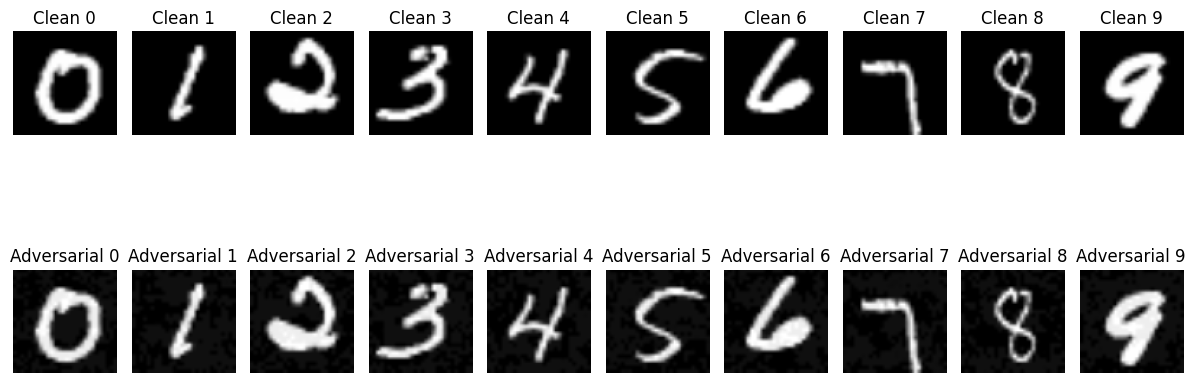

In [31]:
import cv2
import matplotlib.pyplot as plt

# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(10):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
    clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
    adv_samples.append(cv2.resize(np.array(x_test_adv_bim[selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()


In [53]:
#--------------------- C & W Attack -------------------

def cw_loss(y_true, y_pred, target_class, c=1.0):
    correct_logit = tf.reduce_sum(y_pred * y_true, axis=-1)
    wrong_logit = tf.reduce_max((1 - y_true) * y_pred - y_true * 1e10, axis=-1)
    loss = tf.maximum(0.0, c + wrong_logit - correct_logit)
    return loss

# Generate adversarial examples using C&W attack
def cw_attack(model, images, labels, target_class, c=1.0, learning_rate=0.8, num_iterations=10):
    images_adv = tf.identity(images)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(images_adv)
            predictions = model(images_adv)
            loss = cw_loss(labels, predictions, target_class, c)
        
        gradients = tape.gradient(loss, images_adv)
        perturbation = tf.sign(gradients)
        images_adv = images_adv + 0.01 * perturbation  # Adjust the step size
        images_adv = tf.clip_by_value(images_adv, 0, 1)  # Clip the values to valid range
        
    return images_adv

# Example usage of C&W attack
target_class = 0  # Target class for misclassification
x_adv_cw = cw_attack(model, x_test, y_test, target_class)


In [54]:
#--------------------- C & W Attack Evaluation-------------------

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_adv_cw, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_adv_cw), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the CW attack on the subset:", success_rate_subset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0601 - loss: 6.2503
Adversarial Testing Accuracy: 0.08460000157356262
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Success rate of the CW attack on the subset: 0.9154


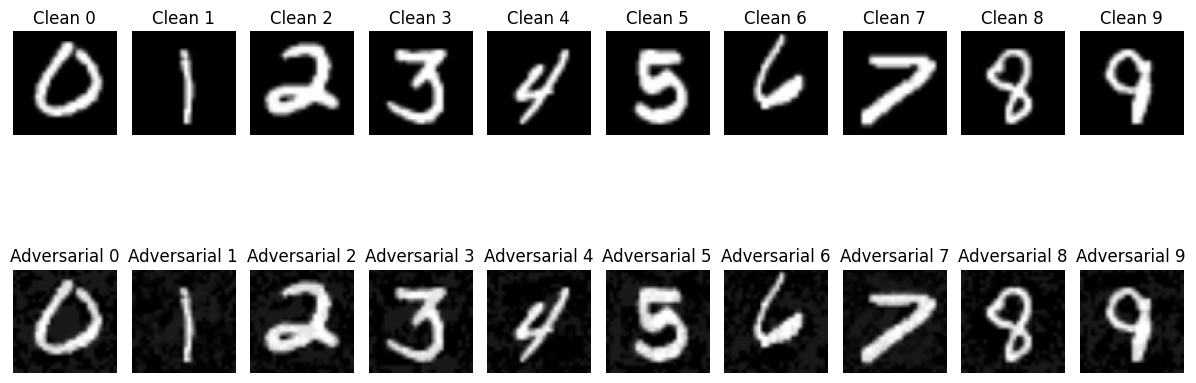

In [55]:
# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(10):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
    clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
    adv_samples.append(cv2.resize(np.array(x_adv_cw[selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()


In [41]:
#--------------------- PGD Attack -------------------

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """
    PGD adversarial attack.
    
    Parameters:
        - model: The model to attack.
        - x: The input to generate adversarial examples.
        - y: The true labels.
        - epsilon: The maximum perturbation allowed.
        - alpha: The step size for each iteration.
        - num_iter: The number of iterations for the attack.
        
    Returns:
        - perturbed_x: The adversarial examples.
    """
    perturbed_x = tf.identity(x)

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_x)
            predictions = model(perturbed_x)
            loss = tf.keras.losses.categorical_crossentropy(y, predictions)

        gradients = tape.gradient(loss, perturbed_x)
        perturbed_x = tf.stop_gradient(perturbed_x + alpha * tf.sign(gradients))
        perturbed_x = tf.clip_by_value(perturbed_x, x - epsilon, x + epsilon)
        perturbed_x = tf.clip_by_value(perturbed_x, 0, 1)

    return perturbed_x

In [50]:
#--------------------- PGD Attack Evaluation -------------------

# Parameters for PGD attack
epsilon = 0.06
alpha = 0.02
num_iter = 200

# Apply PGD attack to test set
x_test_pgd = pgd_attack(model, x_test, y_test, epsilon, alpha, num_iter)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_test_pgd, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_test_pgd), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the PGD attack on the subset:", success_rate_subset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2814 - loss: 3.0795
Adversarial Testing Accuracy: 0.3345000147819519
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Success rate of the PGD attack on the subset: 0.6655


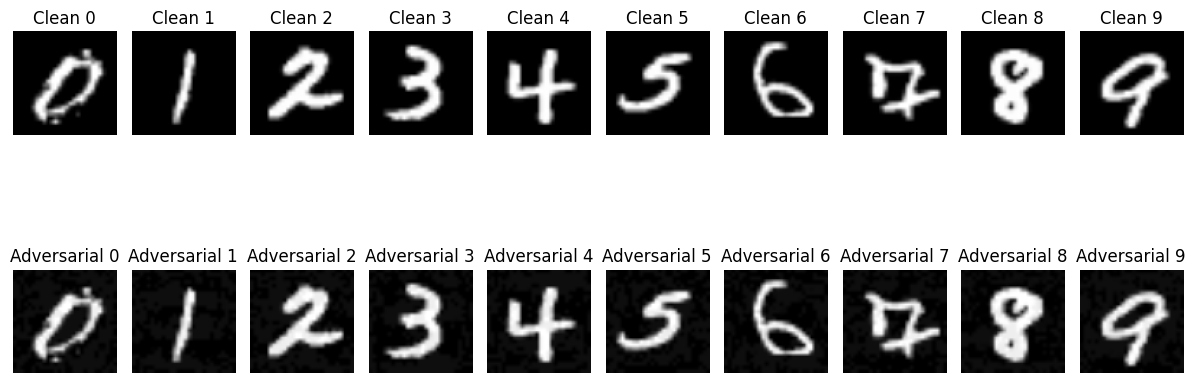

In [37]:
import cv2
import matplotlib.pyplot as plt

# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(10):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
    clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
    adv_samples.append(cv2.resize(np.array(x_test_pgd[selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()

In [56]:
#--------------------- JSMA Attack -------------------

def jsma_attack(model, x, y, epsilon=0.1, num_iterations=100, theta=1.0):
    x_adv = tf.identity(x)
    #y_target = tf.one_hot(y, depth=10)
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            prediction = model(x_adv)
            loss = tf.keras.losses.categorical_crossentropy(y, prediction)
        gradient = tape.gradient(loss, x_adv)
        # Calculate saliency map
        saliency_map = tf.reduce_max(tf.abs(gradient), axis=-1)
        # Perturb the input using saliency map
        perturbation = epsilon * tf.sign(gradient) * saliency_map[..., tf.newaxis]
        x_adv = x_adv + perturbation
        x_adv = tf.clip_by_value(x_adv, x - theta, x + theta)
        x_adv = tf.clip_by_value(x_adv, 0, 1)
    return x_adv.numpy()  # Convert to numpy array


In [61]:
#--------------------- JSMA Attack Evaluation -------------------

# JSMA attack parameters
epsilon_jsma = 0.5
num_iterations_jsma = 150
theta_jsma = 0.5

# Generate adversarial examples for the full test data
x_adv_jsma_all = jsma_attack(model, x_test, y_test, epsilon=epsilon_jsma, num_iterations=num_iterations_jsma, theta=theta_jsma)

# Evaluate the model on the adversarial examples
adv_loss_jsma, adv_acc_jsma = model.evaluate(x_adv_jsma_all, y_test)

# Calculate the success rate of the attack
success_rate_jsma = (1 - adv_acc_jsma) * 100  # Misclassification rate
print("JSMA Attack - Success Rate:", success_rate_jsma, "%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3483 - loss: 44.0683
JSMA Attack - Success Rate: 59.8800003528595 %


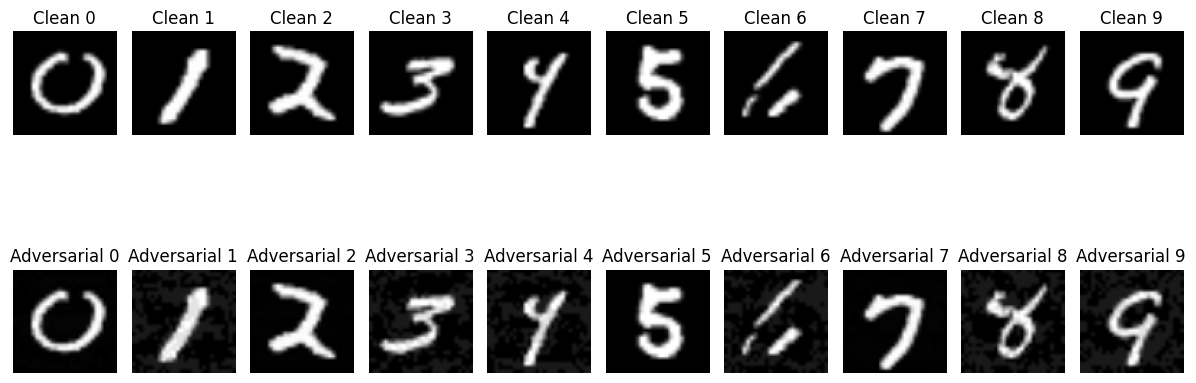

In [60]:
import cv2
import matplotlib.pyplot as plt

# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(10):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
    clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
    adv_samples.append(cv2.resize(np.array(x_adv_jsma_all[selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()